## Cycling Infrastructure Data

Looking deep into the cycling infrastructure

In [1]:
# import libraries

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Cycle lanes

In [2]:
cycle_lane = gpd.read_file('data/cycle_lane_track.json').to_crs('EPSG:27700')

In [3]:
cycle_lane['road_length'] = cycle_lane.length

In [70]:
cycle_lane.dtypes

FEATURE_ID       object
SVDATE           object
CLT_CARR         object
CLT_SEGREG       object
CLT_STEPP        object
CLT_PARSEG       object
CLT_SHARED       object
CLT_MANDAT       object
CLT_ADVIS        object
CLT_PRIORI       object
CLT_CONTRA       object
CLT_BIDIRE       object
CLT_CBYPAS       object
CLT_BBYPAS       object
CLT_PARKR        object
CLT_WATERR       object
CLT_PTIME        object
CLT_ACCESS       object
CLT_COLOUR       object
BOROUGH          object
PHOTO1_URL       object
PHOTO2_URL       object
geometry       geometry
road_length     float64
dtype: object

<Axes: >

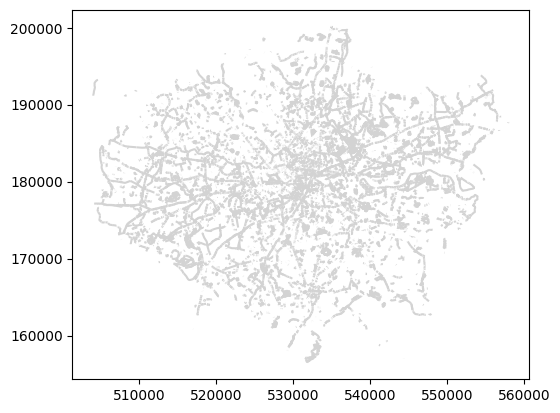

In [71]:
cycle_lane.plot(
    color = 'lightgray'
)

#### Summary Statistics

Calculate the summary statistics for cycle lane

In [72]:
# summary statistics

cycle_lane.length


0         134.240613
1          85.310122
2         251.131588
3         142.592121
4          24.695457
            ...     
24971     562.460493
24972      45.089943
24973    6558.899125
24974      38.864592
24975     254.639478
Length: 24976, dtype: float64

### Points Data

The data we have from the TfL cycling infrastructure

- `cycle_parking.json`
- `restricted_point.json`
- `signage.json`
- `signal.json`
- `traffic_calming.json`



In [4]:
# load points data
cycle_parking = gpd.read_file('data/cycling_infrastructure/cycle_parking.json').to_crs('EPSG:27700')
restricted_point = gpd.read_file('data/cycling_infrastructure/restricted_point.json').to_crs('EPSG:27700')
signage = gpd.read_file('data/cycling_infrastructure/signage.json').to_crs('EPSG:27700')
signal = gpd.read_file('data/cycling_infrastructure/signal.json').to_crs('EPSG:27700')
traffic_calming = gpd.read_file('data/cycling_infrastructure/traffic_calming.json').to_crs('EPSG:27700')

## Summarise by MSOA

Summarise the data by MSOA

In [62]:
# load lsoa data

lsoa = gpd.read_file('data/boundary/LSOA_2011_London_gen_MHW.shp').to_crs('EPSG:27700')
msoa = gpd.read_file('data/boundary/MSOA_2011_London_gen_MHW.shp').to_crs('EPSG:27700')

In [63]:
cycle_lane['road_length'] = cycle_lane.length

In [64]:
joined_data = msoa.sjoin(cycle_lane, predicate = 'intersects')

In [65]:
msoa_cycle_routes = pd.DataFrame(joined_data.groupby('MSOA11CD').road_length.sum())

In [66]:
msoa_cycle_routes

,road_length
MSOA11CD,
E02000001,23386.963770
E02000002,4700.725875
E02000003,10251.449600
E02000004,5797.419100
E02000005,4118.990488
...,...
E02006927,10232.165831
E02006928,2463.088283
E02006929,12968.011701


In [67]:
msoa_cycle = msoa.merge(msoa_cycle_routes, left_on = 'MSOA11CD', right_index = True, how = 'left')

In [73]:
# get cycle casualties

casualties = gpd.read_file('data/2022_casualties.gpkg')
cycle_casualties = casualties[casualties['Casualty Mode of Travel'] == 'Pedal Cycle']

In [74]:
# create dataframe
msoa_casualties = msoa.sjoin(cycle_casualties, predicate = 'contains')

In [75]:
# join with msoa table
msoa_cycle = msoa_cycle.merge(msoa_casualties.groupby('MSOA11CD')['_Casualty Count'].sum(), left_on = 'MSOA11CD', right_index = True)

In [76]:
# normalise
msoa_cycle['cycle_density'] = msoa_cycle['road_length'] / msoa_cycle.area
msoa_cycle['casualty_density'] = msoa_cycle['_Casualty Count'] / msoa_cycle.area

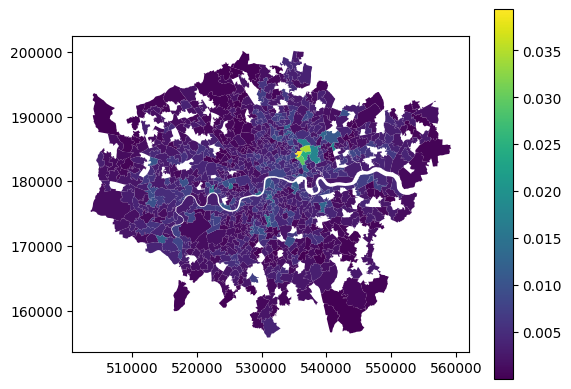

In [77]:
msoa_cycle.plot(
    column = 'cycle_density',
    legend = True
)

plt.show()

<Axes: >

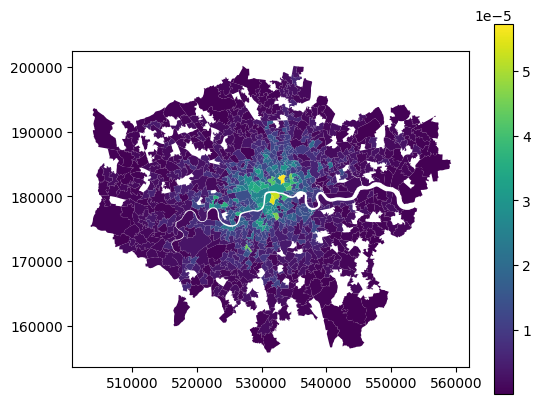

In [78]:
msoa_cycle.plot(
    column = 'casualty_density',
    legend = True
)

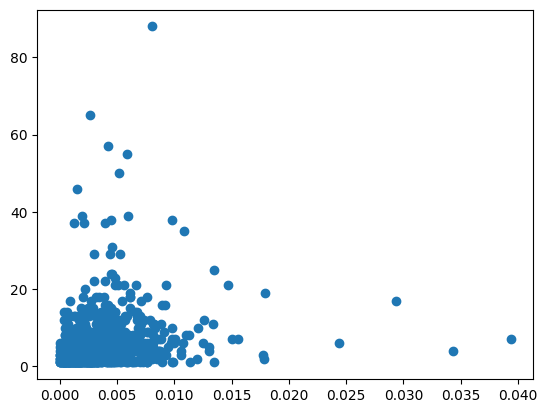

In [79]:
plt.scatter(
    x = msoa_cycle['cycle_density'],
    y = msoa_cycle['_Casualty Count']
)

In [80]:
msoa_cycle_dropna = msoa_cycle.dropna()

# run linear regression
model = sm.OLS(msoa_cycle_dropna['casualty_density'], sm.add_constant(msoa_cycle_dropna['cycle_density']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       casualty_density   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     46.58
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           1.68e-11
Time:                        17:55:54   Log-Likelihood:                 8645.3
No. Observations:                 842   AIC:                        -1.729e+04
Df Residuals:                     840   BIC:                        -1.728e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.841e-06   4.19e-07     11.543      0.000    4.02e-06    5.66e-06
cycle_density     0.0006   8.56e-05      6.825      0.000       0.000       0.001
==============================================================================
Omnibus:                      392.470   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1914.455
Skew:                           2.156   Prob(JB):                         0.00
Kurtosis:                       8.998   Cond. No.                         295.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

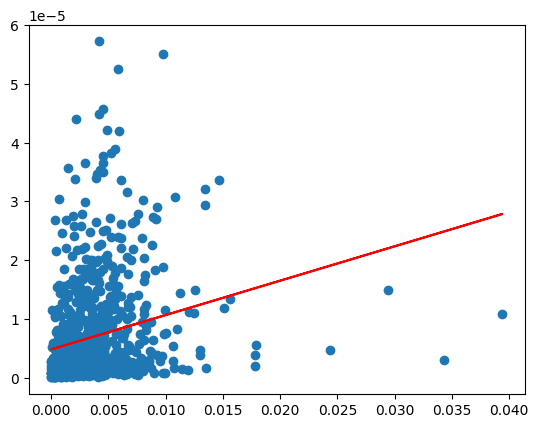

In [81]:
plt.scatter(
    x = msoa_cycle['cycle_density'],
    y = msoa_cycle['casualty_density']
)

plt.plot(
    msoa_cycle_dropna['cycle_density'], results.predict(sm.add_constant(msoa_cycle_dropna['cycle_density'])),
    color = 'red'
)

## Cycling Traffic

### Active travel count

Not using this for analysis!!!

In [10]:
# load data

atc_path = os.path.join('data', 'active_travel_counts')
fn = ['2022 W1 spring-Central.csv', '2022 W1 spring-Inner-Part1.csv', '2022 W1 spring-Inner-Part2.csv', '2022 W1 spring-Outer.csv', '2022 W1 spring-Cycleways.csv']

traffic_df = []
for f in fn:
    traffic_df.append(
        pd.read_csv(os.path.join(atc_path,f))
    )

traffic_concat = pd.concat(traffic_df)


In [24]:
# drop NA values
traffic_concat.Path.dropna(inplace = True)

In [32]:
traffic_concat.Mode.unique()

array(['Cargo bikes', 'Conventional cycles', 'E-scooters', 'Pedestrians',
       'Cycle hire bikes', 'Private cycles', 'Cycles', 'Male cyclists',
       'Female cyclists', 'Unknown cyclists'], dtype=object)

In [55]:
traffic_by_points = pd.DataFrame(traffic_concat[traffic_concat['Mode'] != 'Pedestrians'].groupby(['UnqID', 'Mode']).agg(
    {
        'Count': 'mean'
    }
).reset_index().groupby('UnqID')['Count'].sum()).rename(columns = {'Count': 'cycle_counts'})

In [56]:
traffic_by_points

,cycle_counts
UnqID,
ML0001,14.139062
ML0002,11.954688
ML0003,6.606250
ML0004,4.781250
ML0005,21.690104
...,...
ML2051,16.994792
ML2052,27.078125
ML2055,82.380208


In [11]:
# load locations
locations = pd.read_csv(os.path.join(atc_path, '1 Monitoring locations.csv'))
locations_gdf = gpd.GeoDataFrame(
    locations,
    geometry = gpd.points_from_xy(locations['Easting (UK Grid)'], locations['Northing (UK Grid)'], crs = 'EPSG:27700')
)

In [92]:
traffic_counts = pd.DataFrame(msoa.sjoin(
    locations_gdf.merge(traffic_by_points, left_on = 'Site ID', right_index = True),
    predicate = 'intersects'
).groupby('MSOA11CD').cycle_counts.mean())

In [98]:
msoa_cycle = msoa_cycle.merge(traffic_counts, left_on = 'MSOA11CD', right_index = True)

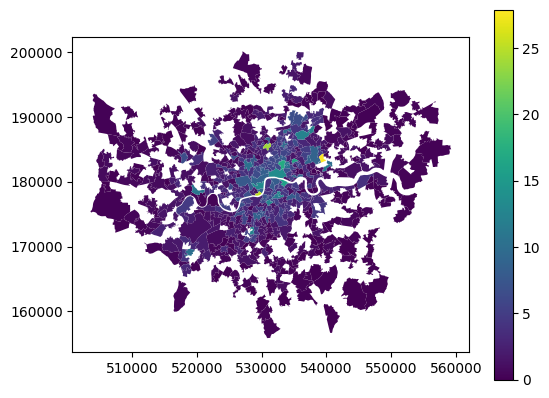

In [106]:
# plot count of cycle
msoa_cycle.plot(
    column = 'cycle_counts',
    legend = True
)

plt.show()

In [120]:
msoa_non0 = msoa_cycle[msoa_cycle['cycle_counts'] != 0].copy()

msoa_non0['casualty_per_cycle'] = msoa_non0['casualty_density'] * 1000000 / msoa_non0['cycle_counts']

In [119]:
msoa_cycle.casualty_per_cycle

inf

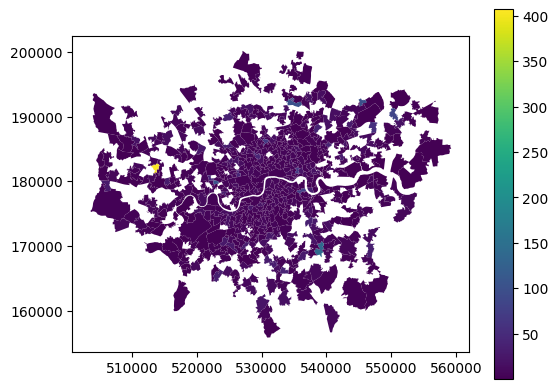

In [121]:
# plot count of cycle
msoa_non0.plot(
    column = 'casualty_per_cycle',
    legend = True
)

plt.show()

In [122]:
msoa_non0.to_file('data/msoa_cycling_data.gpkg', driver = 'GPKG')

### DfT traffic data



In [9]:
london_traffic = pd.read_csv('data/london_traffic_boroughs.csv')

london_traffic

,Unnamed: 0,Local_authority_id,name,ONS_code,year,link_length_km,link_length_miles,cars_and_taxis,all_motor_vehicles
0,56,57,Barnet,E09000003,1993,729.225,453.12,8.194056e+08,9.619031e+08
1,64,66,Hillingdon,E09000017,1993,719.211,446.90,1.089714e+09,1.274280e+09
2,90,93,Tower Hamlets,E09000030,1993,282.780,175.71,4.404428e+08,5.559174e+08
3,93,96,Islington,E09000019,1993,240.063,149.17,2.390268e+08,3.011351e+08
4,100,103,Southwark,E09000028,1993,388.328,241.30,4.257460e+08,5.284653e+08
...,...,...,...,...,...,...,...,...,...
985,6114,177,Sutton,E09000029,2022,468.830,291.32,3.605919e+08,4.560344e+08
986,6115,178,Kingston upon Thames,E09000021,2022,342.960,213.11,4.683174e+08,5.890935e+08
987,6121,185,Harrow,E09000015,2022,472.260,293.45,3.172663e+08,3.890621e+08
988,6136,201,Havering,E09000016,2022,684.150,425.11,7.893772e+08,1.104040e+09


In [28]:
raw_data = pd.read_csv('data/dft_traffic_counts_raw_counts.csv')

In [30]:
raw_data.head(5)

,Count_point_id,Direction_of_travel,Year,Count_date,hour,Region_id,Region_name,Region_ons_code,Local_authority_id,Local_authority_name,...,Buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,All_HGVs,All_motor_vehicles
0,749,E,2014,2014-06-25 00:00:00,7,3,Scotland,S92000003,39,East Ayrshire,...,5.0,31,15.0,4.0,4.0,4.0,13,12.0,52.0,935.0
1,749,E,2014,2014-06-25 00:00:00,8,3,Scotland,S92000003,39,East Ayrshire,...,7.0,103,29.0,3.0,2.0,7.0,18,20.0,79.0,1102.0
2,749,E,2014,2014-06-25 00:00:00,9,3,Scotland,S92000003,39,East Ayrshire,...,14.0,88,21.0,3.0,5.0,9.0,17,19.0,74.0,773.0
3,749,E,2014,2014-06-25 00:00:00,10,3,Scotland,S92000003,39,East Ayrshire,...,8.0,90,31.0,6.0,10.0,7.0,18,17.0,89.0,778.0
4,749,E,2014,2014-06-25 00:00:00,11,3,Scotland,S92000003,39,East Ayrshire,...,18.0,75,38.0,2.0,2.0,3.0,16,24.0,85.0,875.0
